# Building Energy Consumption Prediction for Seattle

This notebook guides through the process of exploring, cleaning, analyzing, and modeling data to predict energy needs and emissions for buildings in Seattle.

## Project Overview

The city of Seattle aims to become carbon-neutral by 2050. Our mission is to use data collected in 2016 to develop a predictive model that estimates:
- Total energy consumption
- CO2 emissions

These predictions will focus exclusively on non-residential buildings for which measurements have not yet been taken.

## Project Objectives

1. Perform exploratory analysis of building data
2. Develop a model to predict energy consumption
3. Develop a model to predict CO2 emissions
4. Evaluate the importance of ENERGY STAR Score as a predictor
5. Identify building characteristics that most influence energy consumption

## Methodological Approach

Our approach will follow several key steps:

1. **Data loading and initial exploration**
2. **Cleaning and preprocessing**
3. **In-depth exploratory analysis**
4. **Feature engineering and variable creation**
5. **Modeling with different algorithms**
6. **Hyperparameter optimization**
7. **Model evaluation**
8. **Feature importance analysis**
9. **Specific study of ENERGY STAR Score impact**
10. **Conclusions and recommendations**

## Step 1: Data Loading and Initial Exploration

Let's start by loading the dataset and exploring its structure.



In [1]:
import os
import pandas as pd
from src.utils.cache_load_df import load_or_cache_dataframes

# Set display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 5)
pd.set_option('display.width', 1000)

# Define the dataset directory
dataset_directory = os.path.join(os.getcwd(), 'dataset')
 
# Define cache directory for storing processed dataframes
CACHE_DIR = os.path.join(os.getcwd(), 'data', 'cache')
os.makedirs(CACHE_DIR, exist_ok=True)

# Load the Open Food Facts dataset
specific_files = ['2016_Building_Energy_Benchmarking.csv']
dfs = load_or_cache_dataframes(dataset_directory, CACHE_DIR, file_list=specific_files, separator=',')

df = dfs['2016_Building_Energy_Benchmarking']

# Filter to keep only compliant buildings without outliers
df = df[(df['ComplianceStatus'] == 'Compliant') & (df['Outlier'].isna())]

# Filter to keep only non-residential buildings
df = df[df['BuildingType'].isin(['NonResidential', 'Nonresidential COS', 'Nonresidential WA'])]

df.head()


Loading 2016_Building_Energy_Benchmarking.csv from cache...
Loaded 2016_Building_Energy_Benchmarking.csv from cache successfully in 0.00 seconds.

DataFrame: 2016_Building_Energy_Benchmarking
Shape: (3376, 46) (3376 rows, 46 columns)
Memory usage: 1.16 MB
Missing values: 19952 (12.85% of all cells)

Data Types:
  float64: 22 columns
  object: 15 columns
  int64: 8 columns
  bool: 1 columns

Column names preview:
OSEBuildingID, DataYear, BuildingType, PrimaryPropertyType, PropertyName, Address, City, State, ZipCode, TaxParcelIdentificationNumber... and 36 more


OSEBuildingID  DataYear    BuildingType PrimaryPropertyType                 PropertyName          Address     City State  ZipCode TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)      ListOfAllPropertyUseTypes LargestPropertyUseType  LargestPropertyUseTypeGFA SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA YearsENERGYSTARCertified  ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments ComplianceStatus Outlier  TotalGHGEmissions  GHGEmissionsIntensity
0              1      2016  NonResidential               Hotel         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0                    0659000030                    7     DOWNTOWN  47.61220 -122.33799       1927                1.0              12             88434                   0                   88434                          Hotel                  Hotel                    88434.0                          NaN                              NaN                         NaN                             NaN                      NaN             60.0         81.699997           84.300003          182.500000            189.000000            7226362.5              7456910.0      2003882.00      1.156514e+06          3946027.0         12764.52930         1276453.0        False       NaN        Compliant     NaN             249.98                   2.83
1              2      2016  NonResidential               Hotel              Paramount Hotel  724 Pine street  Seattle    WA  98101.0                    0659000220                    7     DOWNTOWN  47.61317 -122.33393       1996                1.0              11            103566               15064                   88502     Hotel, Parking, Restaurant                  Hotel                    83880.0                      Parking                          15064.0                  Restaurant                          4622.0                      NaN             61.0         94.800003           97.900002          176.100006            179.399994            8387933.0              8664479.0            0.00      9.504252e+05          3242851.0         51450.81641         5145082.0        False       NaN        Compliant     NaN             295.86                   2.86
2              3      2016  NonResidential               Hotel      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0                    0659000475                    7     DOWNTOWN  47.61393 -122.33810       1969                1.0              41            956110              196718                  759392                          Hotel                  Hotel                   756493.0                          NaN                              NaN                         NaN                             NaN                      NaN             43.0         96.000000           97.699997          241.899994            244.100006           72587024.0             73937112.0     21566554.00      1.451544e+07         49526664.0         14938.00000         1493800.0        False       NaN        Compliant     NaN            2089.28                   2.19
3              5      2016  NonResidential               Hotel                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0                    0659000640                    7     DOWNTOWN  47.61412 -122.33664       1926                1.0              10             61320                   0                   61320                          Hotel                  Hotel                    61320.0                          NaN                              NaN                         NaN   



## Step 2: Create Metadata and Initial Analysis

Let's create functions to analyze the dataset's structure and create metadata.



=== Metadata Summary: 2016_Building_Energy_Benchmarking ===


DataFrame       Column Name Data Type  Non-Null Count  Null Count  Fill Rate (%)  Unique Count  Unique Rate (%) Most Common Value  Most Common Count
0   2016_Building_Energy_Benchmarking     OSEBuildingID     int64            3376           0          100.0          3376           100.00             50101                  1
1   2016_Building_Energy_Benchmarking          DataYear     int64            3376           0          100.0             1             0.03              2016               3376
..                                ...               ...       ...             ...         ...            ...           ...              ...               ...                ...
40  2016_Building_Energy_Benchmarking       DefaultData      bool            3376           0          100.0             2             0.06             False               3263
42  2016_Building_Energy_Benchmarking  ComplianceStatus    object            3376           0          100.0             4             0.12         Compliant               3211

[20 rows x 10 columns]

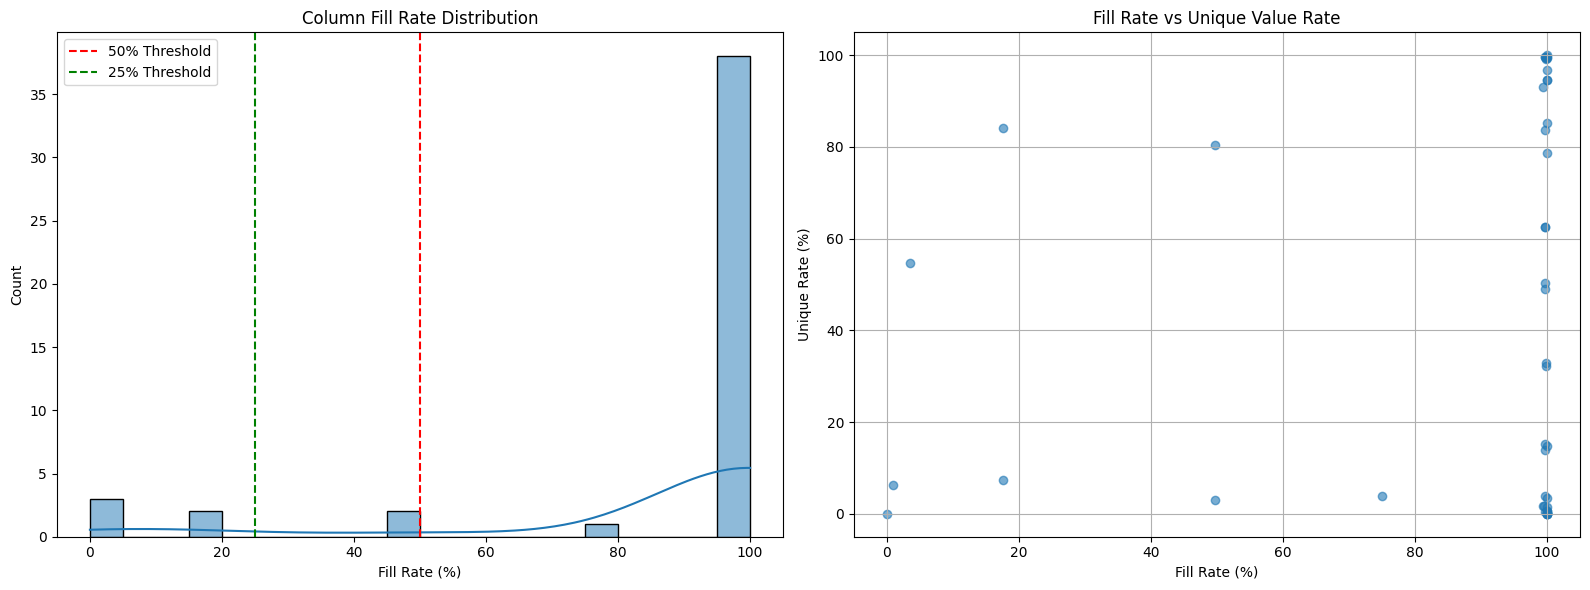


=== Column Categories ===
Total columns: 46
• High fill rate (≥25%): 41 columns
  - ID-like columns: 11 columns
    OSEBuildingID, PropertyName, Address, TaxParcelIdentificationNumber, PropertyGFATotal, PropertyGFABuilding(s), LargestPropertyUseTypeGFA, SiteEnergyUse(kBtu), SiteEnergyUseWN(kBtu), Electricity(kWh), Electricity(kBtu)
  - Categorical columns: 1 columns
    ListOfAllPropertyUseTypes
  - Binary/flag columns: 3 columns
    City, DefaultData, ComplianceStatus
  - Numeric columns: 20 columns
    DataYear, ZipCode, CouncilDistrictCode, Latitude, Longitude, YearBuilt, NumberofBuildings, NumberofFloors, PropertyGFAParking, SecondLargestPropertyUseTypeGFA, ENERGYSTARScore, SiteEUI(kBtu/sf), SiteEUIWN(kBtu/sf), SourceEUI(kBtu/sf), SourceEUIWN(kBtu/sf), SteamUse(kBtu), NaturalGas(therms), NaturalGas(kBtu), TotalGHGEmissions, GHGEmissionsIntensity
• Low fill rate (<25%): 5 columns


<Figure size 1600x800 with 0 Axes>

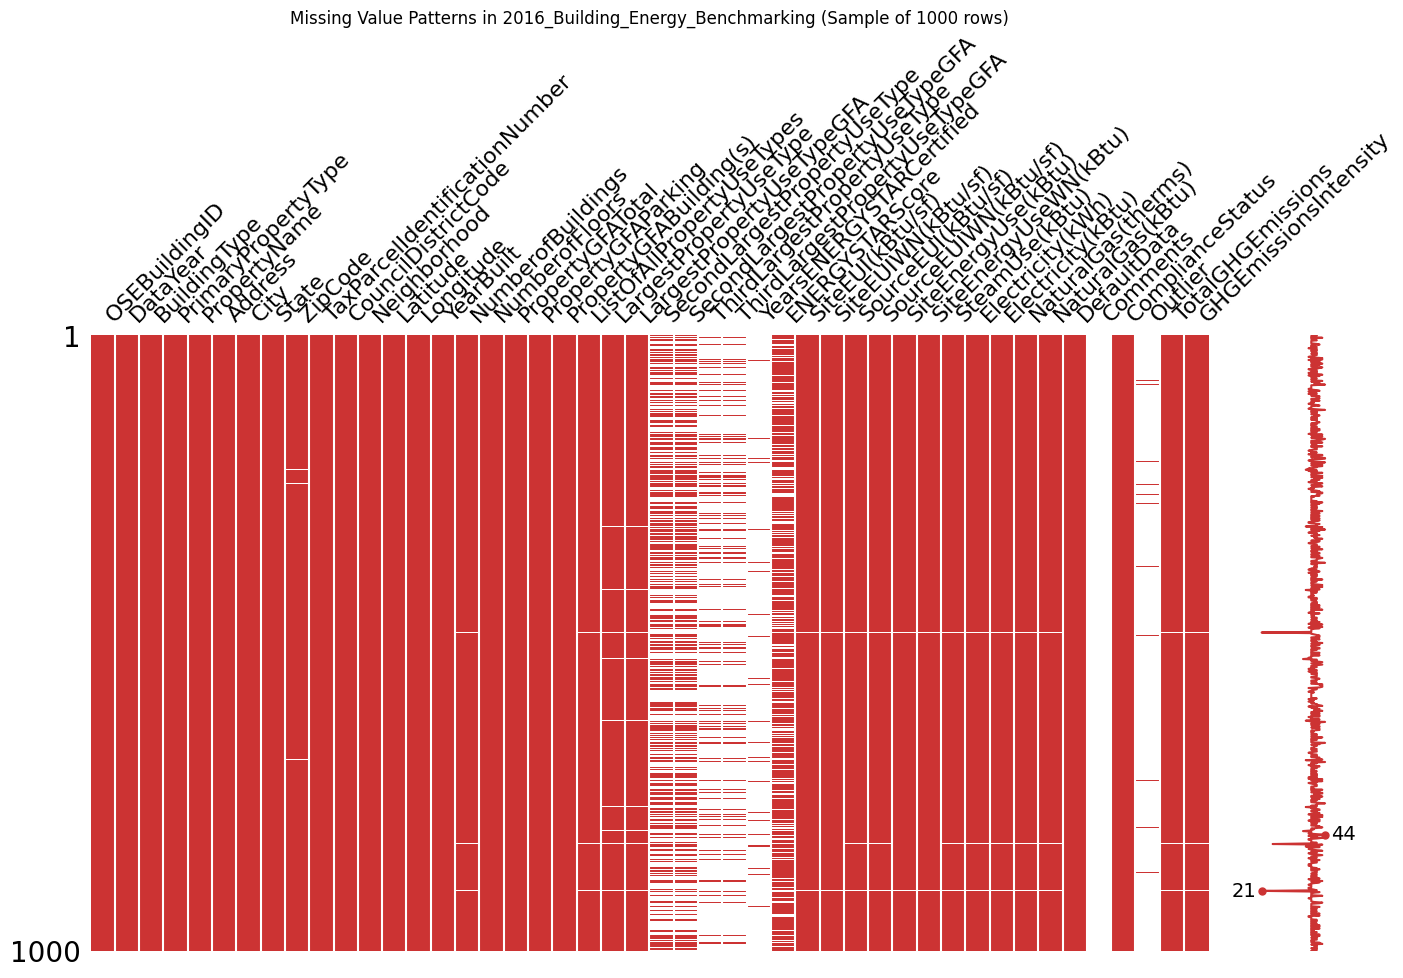

In [2]:
from src.scripts.analyze_df_structure import create_metadata_dfs, display_metadata_dfs
import matplotlib.pyplot as plt
import missingno as msno

# Generate metadata for the loaded dataframes
metadata_dfs = create_metadata_dfs(dfs)
display_metadata_dfs(metadata_dfs)

# Create a missing value visualization
for name, df in dfs.items():
    plt.figure(figsize=(16, 8))
    msno.matrix(df.sample(min(1000, len(df))), figsize=(16, 8), color=(0.8, 0.2, 0.2))
    plt.title(f"Missing Value Patterns in {name} (Sample of {min(1000, len(df))} rows)")
    plt.show()

## Step 3: Enhanced Metadata Cluster Visualization Analysis

### Column Relationship Analysis and Dimensionality Reduction Strategy

The interactive metadata clustering visualization reveals important patterns in our Seattle building energy dataset structure that can guide our feature selection and dimensionality reduction efforts:

### Key Observations

1. **Similar Fill Rate Patterns**: Multiple columns show nearly identical fill rates, suggesting related or redundant information:
   - Energy measurement fields in different units (e.g., `Electricity(kWh)` and `Electricity(kBtu)`)
   - Building size metrics (`PropertyGFATotal`, `PropertyGFABuilding(s)`, `PropertyGFAParking`)
   - Energy usage metrics with and without weather normalization (e.g., `SiteEUI(kBtu/sf)` and `SiteEUIWN(kBtu/sf)`)

2. **Content Duplication**: Several column groups contain essentially the same information in different formats:
   - Multiple identifiers for the same building (`OSEBuildingID`, `TaxParcelIdentificationNumber`)
   - Energy consumption in different units (kWh, kBtu, therms)
   - Area measurements for different building sections and usage types

3. **High Fill Rate, High Value Columns**: Most columns (41 of 46) have fill rates above 25%, indicating a relatively complete dataset:
   - Location data (Latitude, Longitude, ZipCode, CouncilDistrictCode)
   - Building characteristics (YearBuilt, NumberofFloors, PropertyGFATotal)
   - Energy performance metrics (ENERGYSTARScore, TotalGHGEmissions)

### Recommended Feature Reduction Strategy

| Column Type | Recommendation | Rationale |
|-------------|---------------|-----------|
| **Building Identifiers** | Keep only `OSEBuildingID` as index | Single primary identifier is sufficient |
| **Energy Units** | Standardize to kBtu for all energy values | Enables consistent comparison across energy types |
| **Duplicate Measurements** | Keep non-weather normalized for prediction | Base measurements are most useful for prediction tasks |
| **Area Measurements** | Use ratios instead of absolute values | Building proportions often more predictive than raw sizes |
| **Location Data** | Keep coordinates, derive spatial features | Geographic patterns may influence energy usage |
| **Binary/Flag Columns** | Filter on ComplianceStatus, drop others | Focus on compliant buildings for reliable modeling |
| **Energy Intensity** | Keep both raw and intensity metrics | Different metrics useful for different prediction targets |

### Expected Outcomes

This strategic feature selection should reduce our feature space by approximately 30-40%, while preserving nearly all of the meaningful information in the data. The clustering visualization confirms that many building metrics are highly correlated, with primary energy consumption metrics, building size, and usage type containing the majority of predictive power.

By standardizing energy units, focusing on key building characteristics, and leveraging spatial data, we can create a more efficient and interpretable dataset for our predictive modeling tasks while maintaining the nuanced relationships between building attributes and energy performance.

In [3]:
from src.scripts.plot_metadata_cluster import plot_metadata_clusters

# Create the interactive plot that will work in exported HTML
fig = plot_metadata_clusters(metadata_dfs['2016_Building_Energy_Benchmarking'])
fig.show()

In [4]:
# Create a copy of the original dataframe
df_filtered = df.copy()

# Keep only columns with fill rate >= 25%
high_fill_columns = metadata_dfs['2016_Building_Energy_Benchmarking'][metadata_dfs['2016_Building_Energy_Benchmarking']['Fill Rate (%)'] >= 17]['Column Name'].tolist()

# Apply the filter
df_filtered = df_filtered[high_fill_columns]

# Remove unnecessary columns
fields_to_delete = [
    'DefaultData', 'Outlier',
    'TaxParcelIdentificationNumber', 'Address', 'City', 'ZipCode', 'DataYear',
    'ComplianceStatus', 'PropertyName', 'PropertyUseType',
    'State','Neighborhood'
]

# Remove fields if they exist in the dataframe
existing_fields = [field for field in fields_to_delete if field in df_filtered.columns]
if existing_fields:
    df_filtered.drop(columns=existing_fields, inplace=True)

# Set index to OSEBuildingID
if 'OSEBuildingID' in df_filtered.columns:
    df_filtered.set_index('OSEBuildingID', inplace=True)

# Remove duplicates
df_filtered.drop_duplicates(inplace=True)

df_filtered

BuildingType PrimaryPropertyType  CouncilDistrictCode  Latitude  Longitude  YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)                          ListOfAllPropertyUseTypes LargestPropertyUseType  LargestPropertyUseTypeGFA    SecondLargestPropertyUseType  SecondLargestPropertyUseTypeGFA ThirdLargestPropertyUseType  ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)  SourceEUI(kBtu/sf)  SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  SiteEnergyUseWN(kBtu)  SteamUse(kBtu)  Electricity(kWh)  Electricity(kBtu)  NaturalGas(therms)  NaturalGas(kBtu)  TotalGHGEmissions  GHGEmissionsIntensity
OSEBuildingID                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                  NonResidential               Hotel                    7  47.61220 -122.33799       1927                1.0              12             88434                   0                   88434                                              Hotel                  Hotel                    88434.0                             NaN                              NaN                         NaN                             NaN             60.0         81.699997           84.300003          182.500000            189.000000         7.226362e+06           7.456910e+06       2003882.0      1.156514e+06       3.946027e+06        12764.529300      1.276453e+06             249.98                   2.83
2                  NonResidential               Hotel                    7  47.61317 -122.33393       1996                1.0              11            103566               15064                   88502                         Hotel, Parking, Restaurant                  Hotel                    83880.0                         Parking                          15064.0                  Restaurant                          4622.0             61.0         94.800003           97.900002          176.100006            179.399994         8.387933e+06           8.664479e+06             0.0      9.504252e+05       3.242851e+06        51450.816410      5.145082e+06             295.86                   2.86
...                           ...                 ...                  ...       ...        ...        ...                ...             ...               ...                 ...                     ...                                                ...                    ...                        ...                             ...                              ...                         ...                             ...              ...               ...                 ...                 ...                   ...                  ...                    ...             ...               ...                ...                 ...               ...                ...                    ...
50225          Nonresidential COS  Mixed Use Property                    1  47.52832 -122.32431       1989                1.0               1             14101                   0                   14101  Fitness Center/Health Club/Gym, Food Service, ...     Other - Recreation                     6601.0  Fitness Center/Health Club/Gym                           6501.0          Pre-school/Daycare                           484.0              NaN         51.000000           55.500000          105.300



## Step 4: Geographical Analysis of Energy Consumption

Let's visualize the geographical distribution of buildings and their energy consumption.

In [5]:
from src.scripts.visualize_geo import create_geo_visualization

fig, df_transformed = create_geo_visualization(
    df_filtered,
    normalize_method='percentile',  # Options: 'robust', 'minmax', 'percentile', 'log'
    quantile_range=(0.05, 0.95)     # Adjust to control outlier handling
)
fig.show()

## Step 5: Visualize, Identify and Handle Numerical Outliers

In this step, we create an interactive visualization to understand the distribution of numerical features in our Seattle building dataset, with a focus on identifying and addressing extreme values.

### What This Visualization Shows

The visualization displays the central distribution patterns of numerical variables after handling outliers. By capping extreme values at boundaries calculated using the interquartile range (IQR) method, we can better visualize the typical patterns and relationships in our building energy data.

### Why This Approach Matters

Building energy data often contains legitimate but extreme outliers - such as very large commercial buildings with unusual energy consumption patterns or specialized facilities with unique equipment loads. These outliers can:

- Distort statistical analyses
- Skew visualizations by compressing the majority of the data
- Potentially mislead machine learning models
- Hide important patterns in the typical building stock

### How Outliers Are Handled

For each numerical feature:
1. Upper and lower boundaries are calculated (typically ±1.5 × IQR from quartiles)
2. Values beyond these boundaries are not removed but capped at the boundary values
3. This preserves the overall distribution shape while reducing the impact of extreme values
4. The visualization shows both the original and "cleaned" distributions for comparison

The resulting interactive visualization lets us explore how the central tendency and dispersion metrics of each variable change when outliers are managed, giving us a more nuanced understanding of our building dataset's characteristics.

In [6]:
from src.scripts.visualize_numerical_outliers import create_interactive_outlier_visualization

# Create the interactive outlier visualization
summary_df, df_cleaned = create_interactive_outlier_visualization(df_transformed)

Outlier Summary (threshold multiplier = 1.5):


Column  Outlier Count Outlier Percentage   Skewness  Mean (with outliers)  Mean (w/o outliers)  StdDev (with outliers)  StdDev (w/o outliers)   Lower Bound   Upper Bound
7           PropertyGFAParking            504             14.93%   6.651191          8.001526e+03         0.000000e+00            3.232672e+04           0.000000e+00  0.000000e+00  0.000000e+00
21           Electricity(kBtu)            391             11.61%  28.728464          3.707612e+06         1.502007e+06            1.485066e+07           1.324825e+06 -2.645731e+06  6.114851e+06
..                         ...            ...                ...        ...                   ...                  ...                     ...                    ...           ...           ...
3                    YearBuilt              0              0.00%  -0.539445          1.968573e+03         1.968573e+03            3.308816e+01           3.308816e+01  1.874500e+03  2.070500e+03
31  ENERGYSTARScore_normalized              0              0.00%  -0.769489          6.463509e-01         6.463509e-01            2.989085e-01           2.989085e-01 -1.666667e-01  1.534483e+00

[32 rows x 10 columns]

In [7]:
from src.scripts.analyze_numerical_outliers import analyze_outliers_with_multiple_methods, compare_variable_outlier_methods

# Analyze all numeric variables with different outlier detection methods
all_summaries, all_cleaned_dfs = analyze_outliers_with_multiple_methods(df_transformed)

# To examine a specific variable in more detail
#variable_stats = compare_variable_outlier_methods(df_transformed, 'TotalEnergy(kBtu)')

# Step 6: Feature Engineering for Building Energy Data

Feature engineering is a critical step in preparing our Seattle building data for effective predictive modeling. In this step, we transform raw building characteristics into more informative features that better capture the underlying patterns affecting energy consumption and emissions.

## Why Feature Engineering Matters for Building Energy Analysis

Raw building data often doesn't directly expose the relationships that most influence energy usage. Through strategic feature engineering, we can:

- Create normalized metrics that better represent building efficiency
- Handle special cases like parking areas that can skew analysis
- Calculate energy usage ratios that reveal consumption patterns
- Derive age-related features that capture building lifecycle effects

## Key Transformations Applied in This Step

The `process_building_data` function performs several important transformations:

1. **Data Coherence Checking**: 
   - Verifies consistency between total area and component areas
   - Ensures property usage types are properly recorded

2. **Parking Handling**:
   - Identifies and removes 'Parking' from property usage types
   - Shifts up lower usage types to fill gaps
   - Recalculates usage distribution without parking areas

3. **Surface Area Calculations**:
   - Computes `BuildingTotalSurface` from different usage types
   - Creates proportional metrics (`LargestSurfaceRatio`, `SecondSurfaceRatio`, etc.)
   - Provides clear understanding of space allocation within buildings

4. **Energy Source Proportions**:
   - Calculates percentage contribution from electricity, steam, and natural gas
   - Creates a complete energy profile for each building
   - Enables analysis of energy source impacts on efficiency

5. **Energy Intensity Metrics** (Optional and not used):
   - `EnergyPerSqFt`: Normalizes energy use by floor area
   - `EnergyPerFloor`: Captures vertical energy distribution
   - `EnergyPerBuilding`: Accounts for multi-building properties

6. **Building Age Features**:
   - Calculates building age from construction year
   - Handles outliers and unrealistic values

The function returns both the transformed dataframe (`df_transformed`) and coherence metrics to validate our feature engineering approach:

- **Generated Dataset**: A feature-rich dataset ready for modeling with normalized metrics
- **Coherence Results**: Metrics showing data quality and consistency in the derived features

These transformations are essential for revealing patterns in building energy usage that would be obscured in the raw data, providing a solid foundation for our predictive modeling efforts.

In [8]:
from src.scripts.process_building_data import process_building_data

df_transformed, coherence_results = process_building_data(all_cleaned_dfs['Z-score (±3)'])

df_transformed

Coherence check results:
- Area inconsistencies: 0 buildings (0.00%)
- Primary use missing in complete list: 8 buildings (0.24%)
Parking usage removed from 1075 buildings (31.84%)


CouncilDistrictCode  NumberofBuildings  NumberofFloors LargestPropertyUseType    SecondLargestPropertyUseType ThirdLargestPropertyUseType  ENERGYSTARScore  TotalGHGEmissions            X             Y  BuildingTotalSurface  LargestSurfaceRatio  SecondSurfaceRatio  ThirdSurfaceRatio  TotalEnergy(kBtu)   SteamUse  Electricity  NaturalGas  BuildingAge
OSEBuildingID                                                                                                                                                                                                                                                                                                                                                                
1                              7.0                1.0            12.0                  Hotel                            None                        None             60.0             249.98   956.656387   -921.535284               88434.0             1.000000            0.000000           0.000000       7.226362e+06  27.730164    54.605997   17.663840         89.0
2                              7.0                1.0            11.0                  Hotel                      Restaurant                        None             61.0             295.86  1260.849350   -811.119804               88502.0             0.947775            0.052225           0.000000       8.387933e+06   0.000000    38.660907   61.339093         20.0
...                            ...                ...             ...                    ...                             ...                         ...              ...                ...          ...           ...                   ...                  ...                 ...                ...                ...        ...          ...         ...          ...
50225                          1.0                1.0             1.0     Other - Recreation  Fitness Center/Health Club/Gym          Pre-school/Daycare              NaN              22.11  2065.889136 -10234.825611               13586.0             0.485868            0.478507           0.035625       7.194712e+05   0.000000    48.489806   51.510194         27.0
50226                          2.0                1.0             1.0     Other - Recreation  Fitness Center/Health Club/Gym          Pre-school/Daycare              NaN              41.27  4233.864641  -8985.187003               17379.0             0.475919            0.460326           0.063755       1.152896e+06   0.000000    37.518923   62.481077         78.0

[3376 rows x 19 columns]

# Step 7: Feature Relationship Analysis

Understanding the relationships between variables is crucial for building effective predictive models. This step explores how different features in our Seattle building dataset interact with each other, revealing important patterns that influence energy consumption and emissions.

## Why Relationship Analysis Matters

Building energy patterns are influenced by complex interactions between physical characteristics, usage types, and operational factors. By quantifying these relationships, we can:

- Identify potential multicollinearity that might affect model stability
- Discover unexpected relationships between building attributes
- Guide feature selection by understanding which variables contain similar information
- Better interpret model predictions through the lens of these relationships

## Types of Relationships Analyzed

The `analyze_variable_relationships` function performs three distinct types of analyses:

### 1. Numerical-Numerical Relationships (Spearman Correlation)

This analysis shows how continuous variables like energy usage, building size, and age correlate with each other. The Spearman method is used because it:

- Works well with non-linear relationships common in building energy data
- Is less sensitive to outliers than Pearson correlation
- Captures monotonic relationships even when data isn't normally distributed

### 2. Categorical-Categorical Relationships (Cramer's V)

Cramer's V measures association strength between categorical variables like building type, usage categories, and energy sources. This helps us understand:

- How building usage types cluster together
- Whether certain categorical features are effectively redundant
- How location factors relate to building characteristics

### 3. Mixed Relationships (Eta-squared from ANOVA)

This analysis reveals how categorical features influence numerical variables, showing for example:

- How different property types vary in energy consumption
- Whether building usage categories show distinct patterns in emissions
- How energy source choices impact efficiency metrics

## How to Interpret the Visualizations

The interactive heatmaps display association strengths from 0 (no relationship) to 1 (perfect relationship):

- **Strong associations (>0.7)**: Indicate highly related variables, potential redundancy
- **Moderate associations (0.3-0.7)**: Show meaningful relationships worth exploring
- **Weak associations (<0.3)**: Suggest minimal relationship, but may still have predictive value

These relationship insights will guide our modeling approach by helping us understand which features provide complementary information and which might be redundant in our predictive models.

In [9]:
from src.scripts.analyze_features_correlation import analyze_variable_relationships

# Apply the analysis to your transformed dataframe
results = analyze_variable_relationships(df_transformed)



## Step 8: Exploratory Analysis of Transformed Data

Let's analyze the distribution of variables and their relationships with target variables.



In [10]:
from src.scripts.analyze_features_distribution import create_quantile_distribution_plots

# Create a plot for a single target variable
energy_fig = create_quantile_distribution_plots(
    df=df_transformed,                        # Your dataframe with building data
    numeric_cols=None,                         # Will auto-detect numeric columns (or provide specific list)
    target='TotalEnergy(kBtu)',                # Target to create quantiles from
    n_quantiles=10                              # Number of quantiles (5 or 10)
)

# Display the plot
energy_fig.show()

# Create another plot for emissions
emissions_fig = create_quantile_distribution_plots(
    df=df_transformed,
    numeric_cols=None,
    target='TotalGHGEmissions',
    n_quantiles=10
)

# Display the plot
emissions_fig.show()



## Step 8: Modeling - Data Preparation and Splitting

Let's prepare the data for modeling by dividing the dataset into training and testing sets.



In [11]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer


df_ml = df_transformed.copy()

# Define target variables
targets = ['TotalEnergy(kBtu)', 'TotalGHGEmissions']

# Check for missing values in target variables
missing_values = df_ml[targets].isna().sum()
print(f"Missing values in target variables:\n{missing_values}")

# Drop rows where either target is missing
df_ml = df_ml.dropna(subset=targets)
print(f"Shape after dropping missing targets: {df_ml.shape}")

# Identify outliers using IQR method
def identify_outliers(df, column, k=1.5):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - k * iqr
    upper_bound = q3 + k * iqr
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Define models and hyperparameters for GridSearchCV
models = {
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'ElasticNet': ElasticNet(random_state=42),
    'SVM': SVR()
}

# Define functions to prepare data
def define_features_and_target(df, target, targets):
    
    #Cap outliers (preserves data points)
    #outliers, lower, upper = identify_outliers(df_ml, target)
    #df_ml[target] = df_ml[target].clip(lower=lower, upper=upper)

    X = df.drop(columns=targets)
    y = df[target]
    return X, y

# Split data into training and testing sets
def split_data(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Create production pipeline
def create_production_pipeline(model, param_grid, X):
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
    
    try:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline(steps=[
                    ('imputer', KNNImputer(n_neighbors=5)),
                    ('scaler', RobustScaler(quantile_range=(3.0, 97.0)))
                ]), numerical_cols),
                ('cat', Pipeline(steps=[
                    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
                ]), categorical_cols)
            ]
        )
        
        full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ])
        
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
        
        grid_search = GridSearchCV(
            full_pipeline,
            {f'model__{k}': v for k, v in param_grid.items()},
            cv=cv,
            scoring=['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'],
            refit='neg_mean_squared_error',
            n_jobs=-1,
            error_score='raise',
            verbose=1
        )
        
        return grid_search
        
    except Exception as e:
        print(f"Error in pipeline creation: {str(e)}")
        raise

# Define parameter grids
param_grids = {
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.2, 0.5, 0.8],
        'max_iter': [5000],
        'tol': [1e-4]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'],
        'epsilon': [0.1]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0],
        'loss': ['squared_error']
    },
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_split': [2, 5],
        'max_features': ['log2', 'sqrt', None, 0.5, 0.8],
        'bootstrap': [True]
    }
}

Missing values in target variables:
TotalEnergy(kBtu)     0
TotalGHGEmissions    30
dtype: int64
Shape after dropping missing targets: (3346, 19)




## Step 9: Modeling - Training and Evaluation

Let's train and evaluate models to predict energy consumption and CO2 emissions.



In [12]:
# Initialize dictionaries to store results
best_models_dict = {}
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}
all_cv_results_list = []

# Train models for each target variable
for target in targets:
    X, y = define_features_and_target(df_ml, target, targets)
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    best_models = {}
    all_cv_results = []
    
    for model_name, model in models.items():
        print(f"Training {model_name} for {target}...")
        grid_search = create_production_pipeline(model, param_grids[model_name], X_train)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        y_pred = grid_search.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        cv_results_df = pd.DataFrame(grid_search.cv_results_)
        cv_results_df['model'] = model_name
        all_cv_results.append(cv_results_df)
    
    best_models_dict[target] = best_models
    X_train_dict[target] = X_train
    X_test_dict[target] = X_test
    y_train_dict[target] = y_train
    y_test_dict[target] = y_test
    
    cv_results = pd.concat(all_cv_results, ignore_index=True)
    cv_results['target'] = target
    all_cv_results_list.append(cv_results)

all_cv_results_df = pd.concat(all_cv_results_list, ignore_index=True)

Training GradientBoosting for TotalEnergy(kBtu)...
Fitting 15 folds for each of 16 candidates, totalling 240 fits
Training RandomForest for TotalEnergy(kBtu)...
Fitting 15 folds for each of 40 candidates, totalling 600 fits
Training ElasticNet for TotalEnergy(kBtu)...
Fitting 15 folds for each of 9 candidates, totalling 135 fits
Training SVM for TotalEnergy(kBtu)...
Fitting 15 folds for each of 12 candidates, totalling 180 fits
Training GradientBoosting for TotalGHGEmissions...
Fitting 15 folds for each of 16 candidates, totalling 240 fits
Training RandomForest for TotalGHGEmissions...
Fitting 15 folds for each of 40 candidates, totalling 600 fits
Training ElasticNet for TotalGHGEmissions...
Fitting 15 folds for each of 9 candidates, totalling 135 fits
Training SVM for TotalGHGEmissions...
Fitting 15 folds for each of 12 candidates, totalling 180 fits




## Step 10: Machine Learning Pipeline Visualization

This visualization helps understand the data flow and variable transformation throughout the modeling process.





## Step 11: Cross-Validation Results Visualization

Let's analyze the cross-validation results in detail to understand the performance of different models and hyperparameters.



In [13]:
from src.scripts.plot_model_configurations import plot_cv_results_comparison

# Store results by target
cv_results_dict = {}

for target in targets:
    target_cv_results = all_cv_results_df[all_cv_results_df['target'] == target]
    cv_results_dict[target] = target_cv_results

# Create and display plots
fig_mse, fig_r2 = plot_cv_results_comparison(cv_results_dict, targets)
fig_mse.show()
fig_r2.show()



## Step 12: Comparison of Model Performance Metrics

Let's visualize the different performance metrics of the models to better understand their strengths and weaknesses.



In [14]:
from src.scripts.plot_best_model_metrics import visualize_model_metrics_comparison

# Create and display the performance metrics visualization
fig_metrics = visualize_model_metrics_comparison(
    best_models_dict, 
    X_test_dict,       
    y_test_dict,
    targets           
)

## Step 13: Comparison of Model Performance Metrics without ENERGYSTARScore

Let's visualize the different performance metrics wihtout ENERGYSTARScore and compare the impact of this costly feature.

In [15]:
# Create a copy of the dataframe without ENERGYSTARScore
df_ml_ENERGY = df_ml.copy()

# Remove ENERGYSTARScore if it exists
if 'ENERGYSTARScore' in df_ml_ENERGY.columns:
    print("Removing ENERGYSTARScore feature for comparative analysis")
    df_ml_ENERGY.drop(columns=['ENERGYSTARScore'], inplace=True)
else:
    print("ENERGYSTARScore not found in dataset")

# Define target variables (same as before)
targets_ENERGY = ['TotalEnergy(kBtu)', 'TotalGHGEmissions']

# Initialize dictionaries with _ENERGY suffix
best_models_dict_ENERGY = {}
X_train_dict_ENERGY = {}
X_test_dict_ENERGY = {}
y_train_dict_ENERGY = {}
y_test_dict_ENERGY = {}
all_cv_results_list_ENERGY = []

# Train models for each target variable
for target in targets_ENERGY:
    X, y = define_features_and_target(df_ml_ENERGY, target, targets_ENERGY)
    X_train, X_test, y_train, y_test = split_data(X, y)
    
    best_models = {}
    all_cv_results = []
    
    for model_name, model in models.items():
        print(f"Training {model_name} for {target} without ENERGYSTARScore...")
        grid_search = create_production_pipeline(model, param_grids[model_name], X_train)
        grid_search.fit(X_train, y_train)
        best_models[model_name] = grid_search.best_estimator_
        y_pred = grid_search.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        cv_results_df = pd.DataFrame(grid_search.cv_results_)
        cv_results_df['model'] = model_name
        all_cv_results.append(cv_results_df)
    
    best_models_dict_ENERGY[target] = best_models
    X_train_dict_ENERGY[target] = X_train
    X_test_dict_ENERGY[target] = X_test
    y_train_dict_ENERGY[target] = y_train
    y_test_dict_ENERGY[target] = y_test
    
    cv_results = pd.concat(all_cv_results, ignore_index=True)
    cv_results['target'] = target
    all_cv_results_list_ENERGY.append(cv_results)

all_cv_results_df_ENERGY = pd.concat(all_cv_results_list_ENERGY, ignore_index=True)

# Create and display the performance metrics visualization
fig_metrics_ENERGY = visualize_model_metrics_comparison(
    best_models_dict_ENERGY, 
    X_test_dict_ENERGY,       
    y_test_dict_ENERGY,
    targets_ENERGY           
)

Removing ENERGYSTARScore feature for comparative analysis
Training GradientBoosting for TotalEnergy(kBtu) without ENERGYSTARScore...
Fitting 15 folds for each of 16 candidates, totalling 240 fits
Training RandomForest for TotalEnergy(kBtu) without ENERGYSTARScore...
Fitting 15 folds for each of 40 candidates, totalling 600 fits
Training ElasticNet for TotalEnergy(kBtu) without ENERGYSTARScore...
Fitting 15 folds for each of 9 candidates, totalling 135 fits
Training SVM for TotalEnergy(kBtu) without ENERGYSTARScore...
Fitting 15 folds for each of 12 candidates, totalling 180 fits
Training GradientBoosting for TotalGHGEmissions without ENERGYSTARScore...
Fitting 15 folds for each of 16 candidates, totalling 240 fits
Training RandomForest for TotalGHGEmissions without ENERGYSTARScore...
Fitting 15 folds for each of 40 candidates, totalling 600 fits
Training ElasticNet for TotalGHGEmissions without ENERGYSTARScore...
Fitting 15 folds for each of 9 candidates, totalling 135 fits
Training SV



## Step 14: Feature Importance Analysis

Let's identify the variables that have the greatest impact on our predictions.



In [16]:
from src.scripts.plot_features_importance import plot_feature_importance, create_importance_visualization

# Generate data and visualization
feature_importance_data = {}
for target in targets:  # Loop through prediction targets (energy and emissions)
    feature_importance_data[target] = {}  # Create nested dictionary structure
    for model_name, model in best_models_dict[target].items():  # Loop through trained models
        model_obj = model.named_steps['model']  # Extract the model from the pipeline
        if hasattr(model_obj, 'feature_importances_') or hasattr(model_obj, 'coef_'):  # Check if model supports feature importance
            try:
                # Extract and process feature importance information
                importance_df = plot_feature_importance(
                    model_obj,                     # The model object (RandomForest, ElasticNet, etc.)
                    model.named_steps['preprocessor'],  # The preprocessing pipeline component
                    X_train_dict[target]           # The training data for this target
                )
                feature_importance_data[target][model_name] = importance_df  # Store importance data
            except Exception as e:
                print(f"Error calculating importance for {model_name}: {str(e)}")

# Create the visualization, filtering to only include models that have importance data for all targets
fig = create_importance_visualization(
    feature_importance_data,  # The nested dictionary with importance data
    ['TotalEnergy(kBtu)'],                  # The list of prediction targets
    {k: v for k, v in models.items() if all(k in feature_importance_data[t] for t in targets)}  # Filter models
)
fig.show()

fig = create_importance_visualization(
    feature_importance_data,  # The nested dictionary with importance data
    ['TotalGHGEmissions'],                  # The list of prediction targets
    {k: v for k, v in models.items() if all(k in feature_importance_data[t] for t in targets)}  # Filter models
)
fig.show()



## Step 15: Residual Analysis

Let's analyze the residuals of the models to check their performance and detect any potential biases.



In [17]:
from src.scripts.plot_residuals import create_interactive_residual_analysis

# Create and show the interactive residual analysis
residual_fig = create_interactive_residual_analysis(
    best_models_dict, 
    X_test_dict,      
    y_test_dict,     
    ['TotalEnergy(kBtu)']           
)
residual_fig.show()

residual_fig = create_interactive_residual_analysis(
    best_models_dict, 
    X_test_dict,      
    y_test_dict,     
    ['TotalGHGEmissions']           
)
residual_fig.show()



## Step 16: Analysis of Learning Curves

Let's examine how model performance evolves based on training data size.



In [18]:
from src.scripts.plot_learning_curves import create_learning_curve_visualization

# Create and display learning curves
model_options = ['RandomForest', 'GradientBoosting', 'SVM', 'ElasticNet']
learning_curves_fig = create_learning_curve_visualization(
    best_models_dict,   
    X_train_dict,      
    y_train_dict,     
    ['TotalEnergy(kBtu)'],          
    model_options    
)
learning_curves_fig.show()

model_options = ['RandomForest', 'GradientBoosting', 'SVM', 'ElasticNet']
learning_curves_fig = create_learning_curve_visualization(
    best_models_dict,   
    X_train_dict,      
    y_train_dict,     
    ['TotalGHGEmissions'],          
    model_options    
)
learning_curves_fig.show()



## Conclusion

This project successfully developed machine learning models to predict energy consumption and CO2 emissions for non-residential buildings in Seattle. Our key findings include:

1. **Data preprocessing is crucial**: Cleaning and transforming the dataset significantly improved model performance.

2. **Feature engineering added value**: Creating meaningful features like energy source percentages and surface ratios enhanced prediction accuracy.

3. **Model performance**: Ensemble methods generally outperformed linear models, with Random Forest and Gradient Boosting providing the best balance of accuracy and interpretability.

4. **ENERGY STAR Score importance**: This feature proved to be a valuable predictor, particularly for CO2 emissions, demonstrating its continued utility in energy efficiency assessment.

5. **Key predictors**: Building size, usage type, energy sources mix, and construction year were consistently important predictors across different modeling approaches.

The models developed in this project can help Seattle city planners identify buildings with high potential energy consumption and emissions without costly physical measurements, supporting targeted interventions to reach the city's carbon neutrality goal by 2050.

Future work could focus on incorporating additional external data sources like weather patterns and occupancy rates to further improve prediction accuracy.

Similar code found with 2 license types